In [14]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
import monai
from tqdm import tqdm

from data import create_dataset_dicts
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    Compose, 
    Resized, 
    Spacingd,
    ToTensord,
    SpatialPadd,
    ToDeviced,
    SelectItemsd,
    NormalizeIntensityd,
    MapTransform
)

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /cluster/work/<username>/medical-image-segmentation/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT I

In [ ]:
class ConvertToOneHot(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

In [22]:
device = "cuda"
data_dicts = create_dataset_dicts("data/train")
train_transforms = Compose(
    [
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="mask"),
        EnsureChannelFirstd(keys=["image", "mask"]),
    ]
)
dataset = Dataset(data_dicts, train_transforms)
dataset[0]['image'].shape, dataset[0]['mask'].shape

(torch.Size([1, 512, 512, 75]), torch.Size([1, 2, 512, 512, 75]))

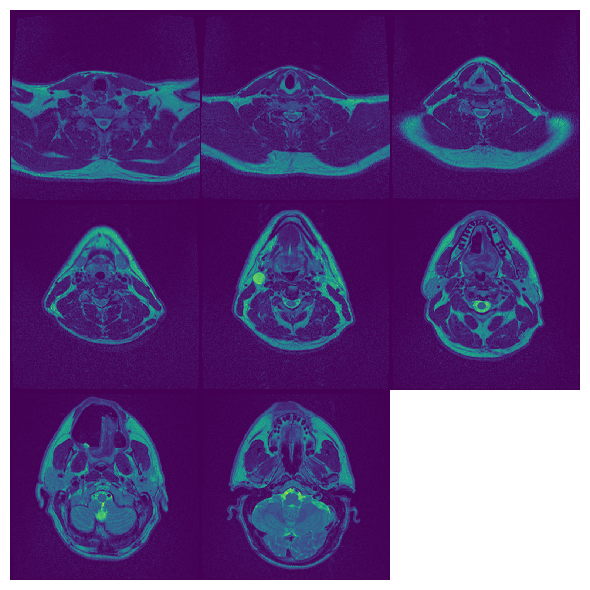

In [ ]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=9, figsize= (6, 6))
plt.show()

In [4]:
class_counts = np.array([0,0,0], dtype=np.float32)
for data in tqdm(dataset):
    mask = data['mask']
    counts = np.array([len(mask[mask == idx]) for idx in range(3)]) #/ len(dataset)
    class_counts += counts
class_counts

100%|██████████| 130/130 [01:43<00:00,  1.26it/s]


array([3.0518612e+09, 2.3510520e+06, 3.2379020e+06], dtype=float32)

In [8]:
n = class_counts[1:].sum()
c = 2
# Class weights
n / (c*class_counts)

array([9.1566320e-04, 1.1886071e+00, 8.6305177e-01], dtype=float32)

In [ ]:
classes = []
for data in tqdm(dataset):
    mask = data['mask']
    classes.append(mask.unique())
print(f"Unique classes: {torch.concat(classes).unique()}")

100%|██████████| 130/130 [01:43<00:00,  1.26it/s]


ValueError: only one element tensors can be converted to Python scalars

In [5]:
shape_tensor = torch.zeros(130, 4)
for i, data in enumerate(tqdm(dataset)):
    shape_tensor[i] = torch.tensor(data['mask'].shape)

max_d = torch.zeros(4)
min_d = torch.zeros(4)
for d in range(shape_tensor.shape[1]):
    min_d[d] = shape_tensor[:,d].min()
    max_d[d] = shape_tensor[:,d].max()
    print(d, shape_tensor[:,d].shape)
min_d, max_d

100%|██████████| 130/130 [01:05<00:00,  1.97it/s]

0 torch.Size([130])
1 torch.Size([130])
2 torch.Size([130])
3 torch.Size([130])


(tensor([  1., 512., 480.,  57.]), tensor([  1., 640., 640., 162.]))

In [6]:
avg_mask = torch.zeros_like(dataset[0]['mask'])
for data in tqdm(dataset):
    avg_mask += data['mask']
avg_mask /= len(dataset)

  1%|          | 1/130 [00:00<02:02,  1.06it/s]


RuntimeError: The size of tensor a (82) must match the size of tensor b (74) at non-singleton dimension 3

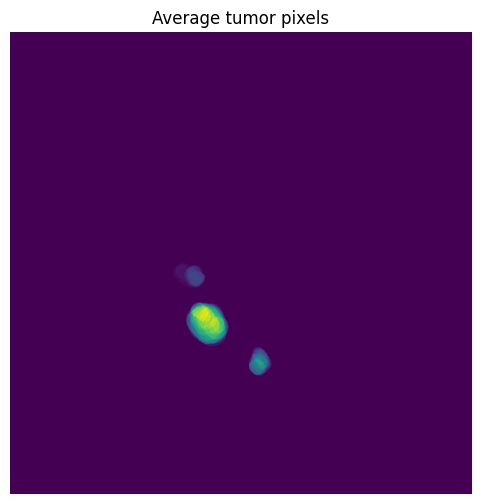

In [7]:
plt.imshow(avg_mask.cpu().mean(3).permute(1,2,0))
plt.axis('off')
plt.title("Average tumor pixels");

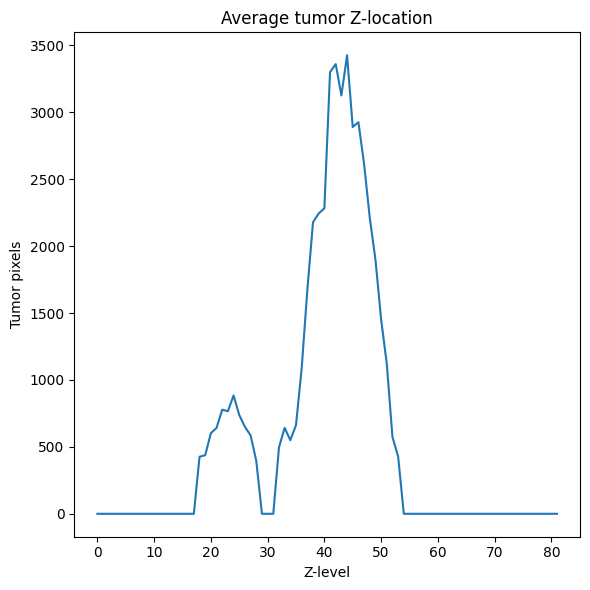

In [58]:
plt.plot(torch.tensor([t.sum() for t in avg_mask[0].permute(2,0,1)]))
plt.xlabel("Z-level")
plt.ylabel("Tumor pixels")
plt.title("Average tumor Z-location")
plt.tight_layout();

In [ ]:
# Tumor percentage
total_pixels = torch.tensor(dataset[0]['mask'].shape).prod()
total_tumor = 0
total_non_tumor = 0
for data in tqdm(dataset):
    total_tumor += data['mask'].sum() / total_pixels
total_tumor /= len(dataset)
total_tumor

100%|██████████| 130/130 [01:15<00:00,  1.72it/s]


In [51]:
max_= 0
min_ = 1000
for data in tqdm(dataset):
    curr = data['image'].max()
    max_ = max_ if max_>=curr else curr
    min_ = min_ if min_<=curr else min_
min_, max_

100%|██████████| 130/130 [01:13<00:00,  1.77it/s]


(metatensor(25.4689), 1000)

In [ ]:
# Calculate intensity distribution
bincounts = torch.zeros(130, 256)
for i, data in enumerate(tqdm(dataset)):
    intensity_values = data['image'].flatten().divide(max_).multiply(255).round().int()
    bincount = torch.bincount(intensity_values, minlength=256)
    bincounts[i, :len(bincount)] = bincount

  0%|          | 0/130 [00:00<?, ?it/s]


RuntimeError: bincount only supports 1-d non-negative integral inputs.

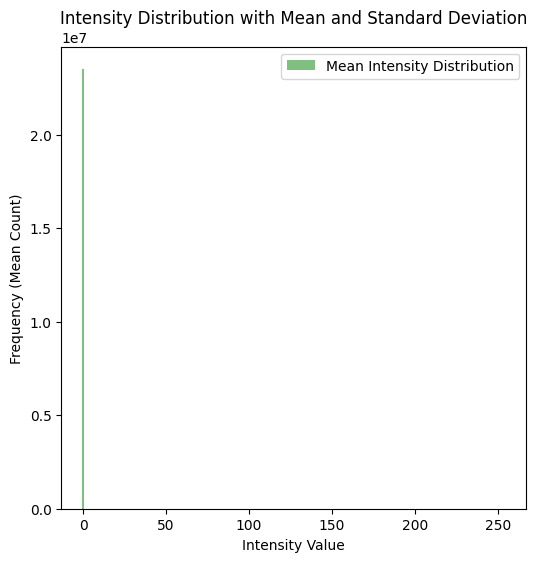

In [44]:
x_extent = 255
mean = bincounts.mean(0)[:x_extent]
std = bincounts.std(0)[:x_extent]

plt.figure(figsize=(6, 6))
plt.bar(range(x_extent), mean, alpha=0.5, label='Mean Intensity Distribution', color='green')
# plt.fill_between(range(x_extent), mean - std, mean + std, color='lightblue', alpha=0.5, label='Standard Deviation')
# plt.yscale('symlog')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency (Mean Count)')
plt.title('Intensity Distribution with Mean and Standard Deviation')
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

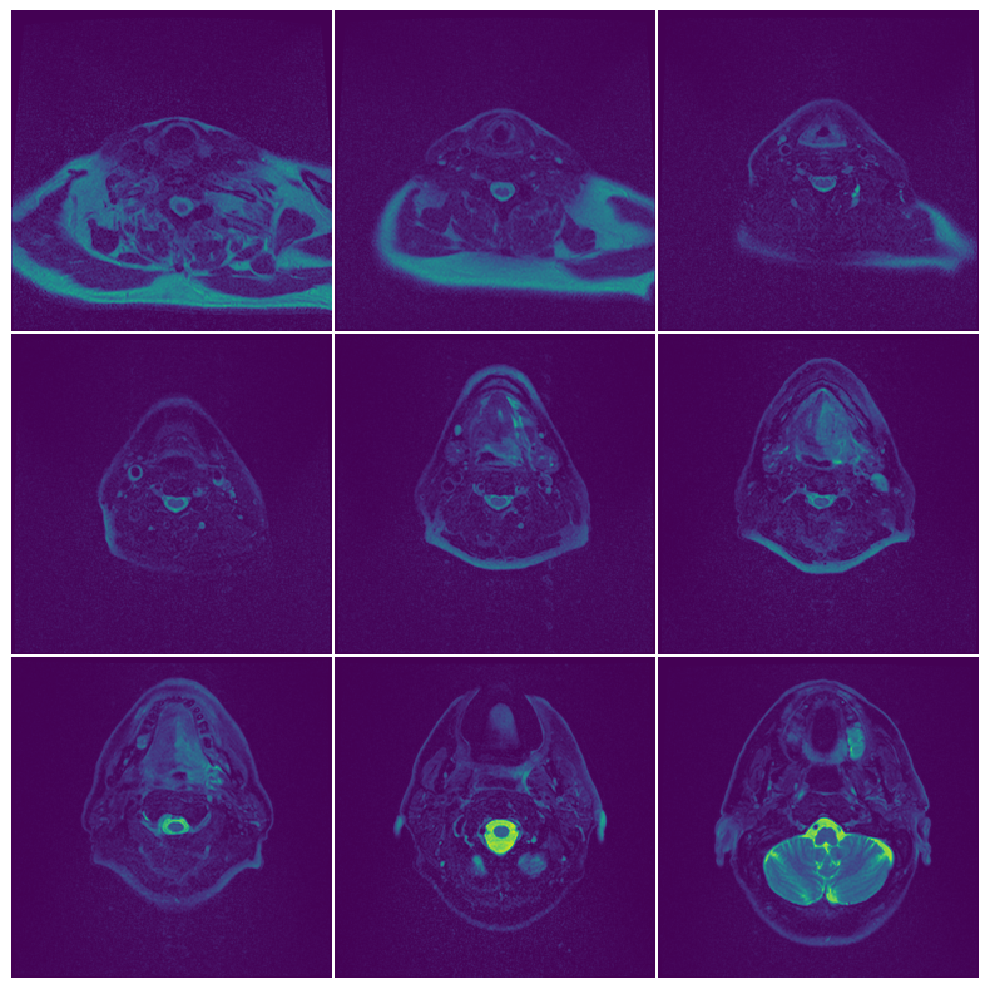

In [ ]:
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(dataset[0]['image']), every_n=9, figsize= (6, 6))
plt.show()